<a href="https://colab.research.google.com/github/Lucs1590/vgg_bpca/blob/master/notebooks/vgg_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG NET
Here we are using a VGG net with 19 layers with the dataset cifar 100.

We are trying to reproduce the results of the paper [1] and after we will try to change some layers and see how it affects the results.

[1] https://arxiv.org/pdf/1409.1556.pdf


# Imports

In [59]:
import random
import time
import os
from uuid import uuid4

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.applications.vgg16 import decode_predictions, preprocess_input
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
from keras.datasets import cifar100
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.models import Sequential, model_from_json, load_model
from keras.optimizers import (Adam, SGD)
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import data_utils, layer_utils, to_categorical, load_img, img_to_array
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!nvidia-smi

Mon Mar 13 23:01:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load the dataset

In [4]:
np.random.seed(77)
tf.random.set_seed(77)

In [5]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

We will split the test set in two parts, where one of this will be used to validation. After that we will declare the classes and plot some random images.

In [6]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.7)

In [7]:
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
           'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
           'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

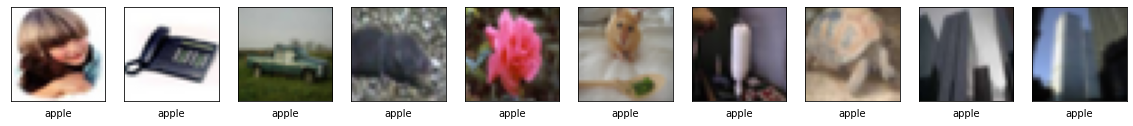

In [62]:
plt.figure(figsize=(20, 3))
random_images = []

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    numb = random.randint(0,len(X_train))

    plt.imshow(X_train[numb], cmap="gray")
    plt.xlabel(labels[y_train[numb].astype(int)[0]])

    img_path = f'{uuid4()}.png'

    plt.imsave(img_path, X_train[numb])
    random_images.append(img_path)
    
plt.show()

Here the data will be converted to a scale between 0 and 1.

In [9]:
print(f'Train: {len(X_train)}')
print(f'Test: {len(X_test)}')
print(f'Validation: {len(X_valid)}')
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_valid = to_categorical(y_valid, 100)

Train: 50000
Test: 3000
Validation: 7000


## Data Augmentation
The last thing in this step is apply a lot of filters to the train dataset.



In [10]:
datagen = ImageDataGenerator(
    height_shift_range=0.25,
    width_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    rotation_range=45,
    brightness_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

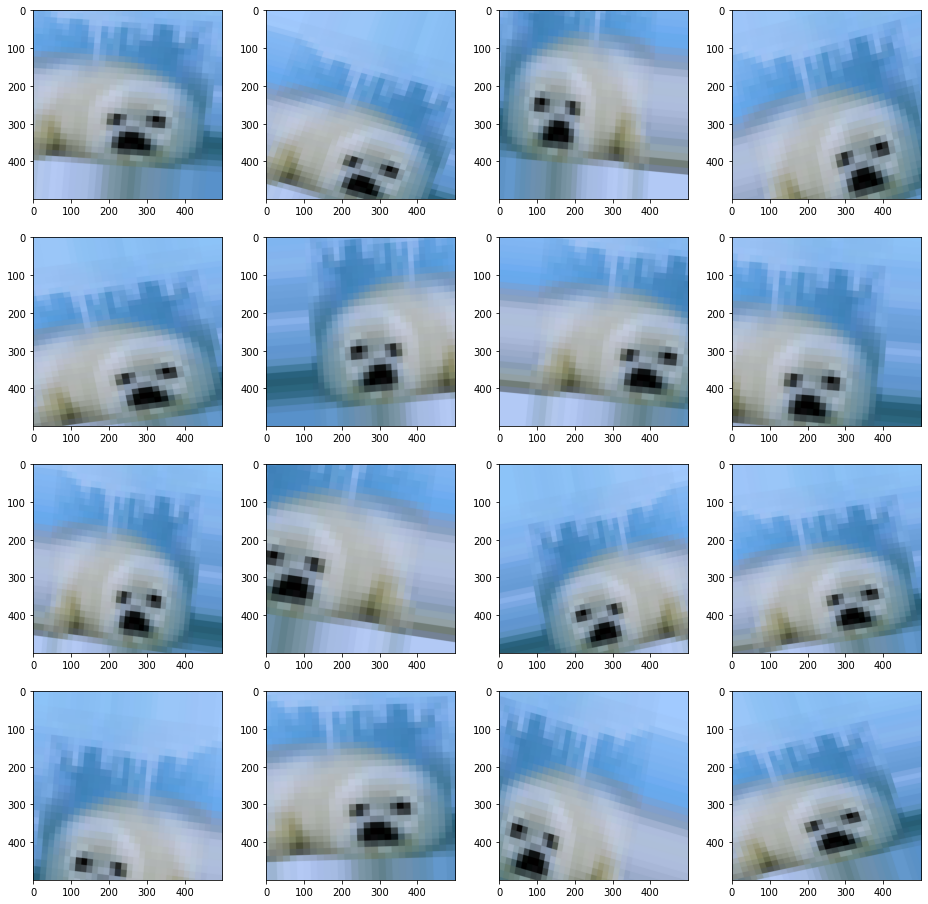

In [50]:
plt.imsave('test.png', X_train[numb])

img = load_img('/content/test.png', target_size= (500,500))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(16, 16))

for i in range(1,17):
   plt.subplot(4, 4, i)
   batch = pic.next()
   image_ = batch[0].astype('uint8')
   plt.imshow(image_)
plt.show()

# VGG Archtecture

## VGG 16
- The cons of this architecture are that it is slow to train and produces the model with very large size.
- A total of 13 convolutional layers are stacked one after the other and 3 dense layers for classification.


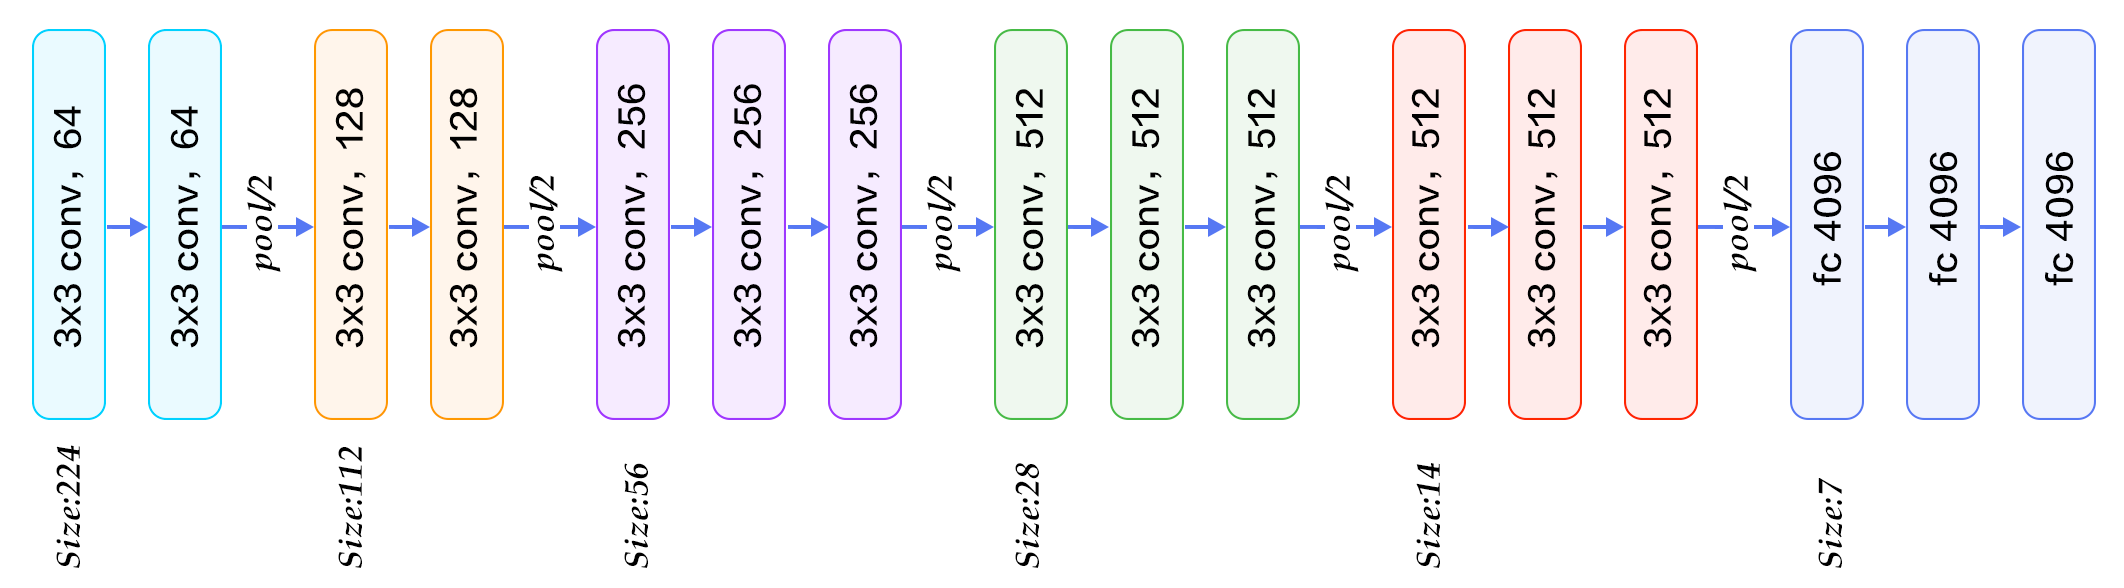

In [12]:
layers = VersionAwareLayers()
WEIGHTS_PATH = (
    "https://storage.googleapis.com/tensorflow/keras-applications/"
    "vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5"
)
WEIGHTS_PATH_NO_TOP = (
    "https://storage.googleapis.com/tensorflow/"
    "keras-applications/vgg16/"
    "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
)

def VGG16(include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation="softmax"):
    if not (weights in {"imagenet", None} or tf.io.gfile.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded.  Received: "
            f"weights={weights}"
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights` as `"imagenet"` with `include_top` '
            "as true, `classes` should be 1000.  "
            f"Received `classes={classes}`"
        )

    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=224,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv1")(img_input)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv2")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv1")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv2")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv1")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv2")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv3")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv1")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv2")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv3")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv1")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv2")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv3")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block5_pool")(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name="flatten")(x)
        x = layers.Dense(4096, activation="relu", name="fc1")(x)
        x = layers.Dense(4096, activation="relu", name="fc2")(x)

        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes, activation=classifier_activation, name="predictions"
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    vgg16_model = training.Model(inputs, x, name="vgg16")

    if weights == "imagenet":
        if include_top:
            weights_path = data_utils.get_file(
                "vgg16_weights_tf_dim_ordering_tf_kernels.h5",
                WEIGHTS_PATH,
                cache_subdir="models",
                file_hash="64373286793e3c8b2b4e3219cbf3544b",
            )
        else:
            weights_path = data_utils.get_file(
                "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
                WEIGHTS_PATH_NO_TOP,
                cache_subdir="models",
                file_hash="6d6bbae143d832006294945121d1f1fc",
            )
        vgg16_model.load_weights(weights_path)
    elif weights is not None:
        vgg16_model.load_weights(weights)

    return vgg16_model

# Training

Training VGG-16 model from stretch.

## Loading model from scratch

In [ ]:
# VGG16
vgg16_model = VGG16(
    include_top=False,
    # weights='imagenet',
    input_shape=X_train[0].shape,
    classes=len(labels),
    pooling="max"
)

for idx, layer in enumerate(vgg16_model.layers):
    print (idx, layer)
    layer.trainable = False

vgg16_model.summary()

0 <keras.engine.input_layer.InputLayer object at 0x7f46afe4c640>
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46afe93f40>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46afbf7e20>
3 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f46afe46a90>
4 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46afeca9d0>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46af666640>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f46afea1e80>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46afebf220>
8 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46afe5d3d0>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46aff1ea00>
10 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f46afe67d30>
11 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46ae27ab50>
12 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46afe5ddc0>
13 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f46afe67b50>


Add classification layers.

In [ ]:
model = Sequential()
model.add(vgg16_model)
# model.add(layers.Flatten(name="flatten"))
model.add(layers.Dense(4096, activation="relu", name="fc1"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4096, activation="relu", name="fc2"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(labels), activation='softmax', name="predictions"))

for idx, layer in enumerate(model.layers):
    print (idx, layer)
    layer.trainable = True

model.summary()
vgg16_model = model
del model

0 <keras.engine.functional.Functional object at 0x7f46afe11a00>
1 <keras.layers.core.dense.Dense object at 0x7f46afe189a0>
2 <keras.layers.regularization.dropout.Dropout object at 0x7f46afdfd1f0>
3 <keras.layers.core.dense.Dense object at 0x7f46afe781c0>
4 <keras.layers.core.dense.Dense object at 0x7f46ae2a5400>
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 fc1 (Dense)                 (None, 4096)              2101248   
                                                                 
 dropout_7 (Dropout)         (None, 4096)              0         
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 pre

## Loading model with pre-trained weights

In [25]:
with open('/content/gdrive/MyDrive/Projetos/colab-tests/cifar100_vgg16_warmed_up.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    vgg16_model = model_from_json(loaded_model_json)


vgg16_model.load_weights("/content/gdrive/MyDrive/Projetos/colab-tests/cifar100_vgg16_warmed_up.h5")

# vgg16_model.load_weights(
#     '/content/gdrive/MyDrive/cifar100_vgg16_2.h5',
#     by_name=True,
#     skip_mismatch=True
# )


Unfreezing some layers.

In [26]:
def change_trainable_attribute(layers_to_change: list, layers: VersionAwareLayers) -> None:
  for idx, layer in enumerate(layers):
    new_value = False
    if idx in layers_to_change:
      new_value = True
      print(f'  {layer.name} will be trained')
    layer.trainable = new_value

In [27]:
trainable_layers = list(range(15,19))

for idx, layer in enumerate(vgg16_model.layers):
  try:
    layer.summary()
    change_trainable_attribute(trainable_layers, layer.layers)
  except AttributeError:
    layer.trainable = False

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [28]:
model_checkpointer = ModelCheckpoint('cifar100_vgg16.h5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=6, verbose=1, factor=0.2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, mode='auto', verbose=1, patience=30)

# optimizer = Adam(learning_rate=1e-5)
optimizer = SGD(momentum=0.9)

vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

start_time = time.perf_counter()
history = vgg16_model.fit(
    datagen.flow(X_train, y_train, batch_size=64, shuffle=True),
    validation_data=(X_valid, y_valid), epochs=350, verbose=1,
    callbacks=[
        model_checkpointer,
        # early_stopping,
        # reduce_lr
    ]
)
print(f'Time to train: {str("{0:.2f}".format((time.perf_counter() - start_time) / 60))}')

Epoch 1/350
782/782 [==============================] - ETA: 0s - loss: 31.6991 - accuracy: 0.0113
Epoch 1: val_accuracy improved from -inf to 0.00943, saving model to cifar100_vgg16.h5
782/782 [==============================] - 34s 43ms/step - loss: 31.6991 - accuracy: 0.0113 - val_loss: 4.6214 - val_accuracy: 0.0094
Epoch 2/350
781/782 [============================>.] - ETA: 0s - loss: 4.6309 - accuracy: 0.0104
Epoch 2: val_accuracy did not improve from 0.00943
782/782 [==============================] - 32s 41ms/step - loss: 4.6308 - accuracy: 0.0104 - val_loss: 4.6136 - val_accuracy: 0.0084
Epoch 3/350
782/782 [==============================] - ETA: 0s - loss: 4.6280 - accuracy: 0.0097
Epoch 3: val_accuracy improved from 0.00943 to 0.00986, saving model to cifar100_vgg16.h5
782/782 [==============================] - 33s 42ms/step - loss: 4.6280 - accuracy: 0.0097 - val_loss: 4.6179 - val_accuracy: 0.0099
Epoch 4/350
781/782 [============================>.] - ETA: 0s - loss: 4.6246 - 

In [29]:
model_json = vgg16_model.to_json()
with open("cifar100_vgg16.json", "w") as json_file:
    json_file.write(model_json)

In [30]:
!cp /content/cifar100_vgg16.h5 /content/gdrivTe/MyDrive/cifar100_vgg16_2.h5
!cp /content/cifar100_vgg16.json /content/gdrive/MyDrive/cifar100_vgg16_2.json

cp: cannot create regular file '/content/gdrivTe/MyDrive/cifar100_vgg16_2.h5': No such file or directory


# Test

In [31]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

scores = vgg16_model.evaluate(X_valid, y_valid, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

219/219 [==============================] - 2s 10ms/step - loss: 4.6085 - accuracy: 0.0101
Accuracy: 1.01%


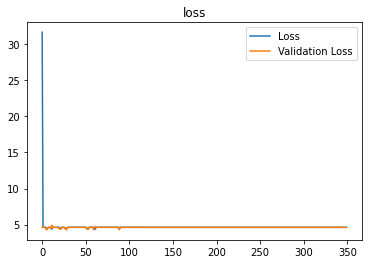

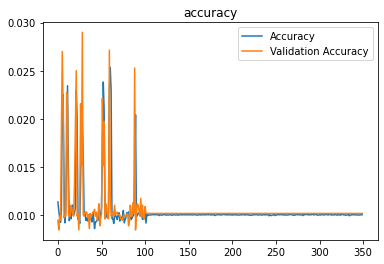

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.legend(["Loss","Validation Loss"])
plt.savefig("loss.png",dpi=300,format="png")
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.legend(["Accuracy","Validation Accuracy"])
plt.savefig("accuracy.png",dpi=300,format="png")

219/219 [==============================] - 2s 7ms/step


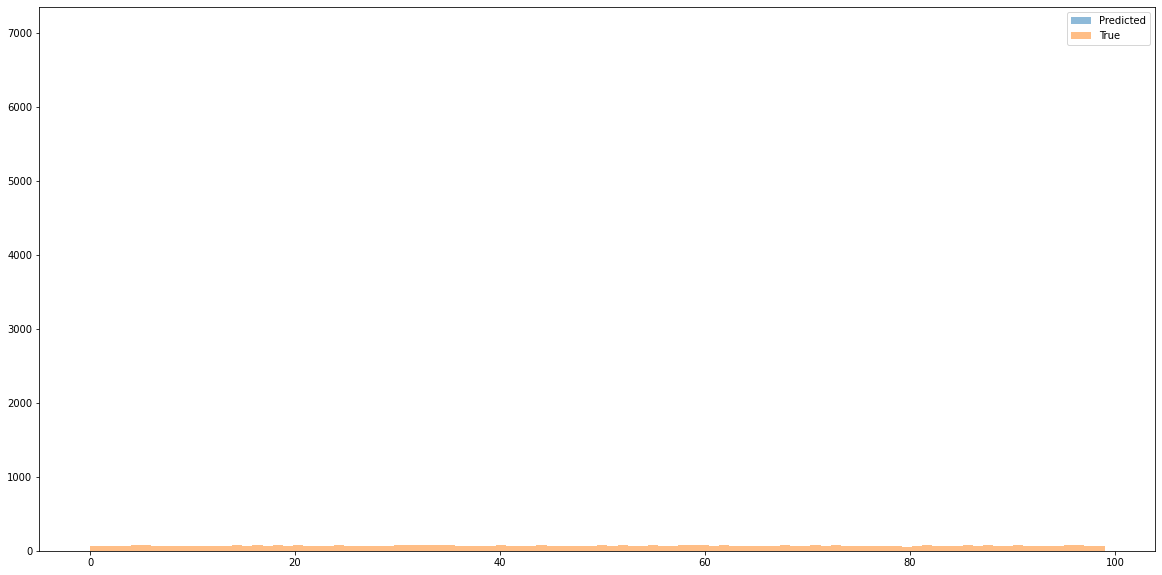

In [33]:
# plot the probability distribution of the predictions
y_pred = vgg16_model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)

plt.figure(figsize=(20,10))
plt.hist(y_pred, bins=100, alpha=0.5, label='Predicted')
plt.hist(y_true, bins=100, alpha=0.5, label='True')
plt.legend(loc='upper right')
plt.show()
